<a name="Load"></a>
## Load Data 

Download the images from a GCP bucket (this only needs to run if running on colab or first run on local):

In [1]:
import pandas as pd
import requests
import io
import urllib.parse

import numpy as np

from PIL import Image



import os

import random

import datetime as dt

import matplotlib.pyplot as plt

In [2]:
# import numpy as np
import torch
# from skimage import io
from torch.utils.data import Dataset
from torchvision import transforms

In [3]:
import torchvision
from torchvision import models, transforms

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F

In [4]:
import tqdm

from torch.cuda.amp import GradScaler, autocast

In [5]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './data/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


Read in the train, test, and sample submission CSV files as pandas dataframes:

In [6]:
BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

In [7]:
# Read in csv files.
train_path = os.path.join(os.path.dirname(IMAGE_DIR), 'train.csv')
if os.path.exists(train_path):
    train = pd.read_csv(train_path)
else:
    train = read_csv_from_web('train.csv')
    train.to_csv(train_path, index=False)
    
test_path = os.path.join(os.path.dirname(IMAGE_DIR), 'test.csv')
if os.path.exists(test_path):
    test = pd.read_csv(test_path)
else:
    test = read_csv_from_web('test.csv')
    test.to_csv(test_path, index=False)
  

    
extra_path = os.path.join(os.path.dirname(IMAGE_DIR), 'extra_images.csv')
if os.path.exists(extra_path):
    extra = pd.read_csv(extra_path)
else:
    extra = read_csv_from_web('extra_images.csv')
    extra.to_csv(extra_path, index=False)
   
# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

Quickly check the data

In [8]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [9]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [10]:
extra.head()

,image_id,turtle_id
0,ID_Y0KYE5XD,t_id_he7JTQxO
1,ID_8JTIQ4UI,t_id_he7JTQxO
2,ID_LSXPZYSN,t_id_he7JTQxO
3,ID_SHZ2HDSP,t_id_he7JTQxO
4,ID_6TOFB06E,t_id_xry0Yg2j


### Simple Dataset 
Treats the problem as a simple classification problem

In [11]:
# Dataset to generate triplets (anchor, positive, negative) for training
class TurtleDataSet(Dataset):
    """
    Args:
        root_dir (string): Root directory of dataset  images
        labels_df (Dataframe): 
        label_ids (list): list of ids in training set
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        include_orientation (boolean, optional): whether to include orientation as well
    """
    def __init__(self, root_dir, labels_df, label_ids, transform=None, include_orientation=True):

        self.root_dir = root_dir
        self.include_orientation = include_orientation
        if self.include_orientation:
            # self.df = pd.concat([labels_df['image_id'], 
            #                      pd.get_dummies(labels_df['image_location']), 
            #                      pd.get_dummies(labels_df['turtle_id'])], 
            #                     axis=1)
            self.df = labels_df
        else:
            self.df = labels_df[['image_id', 'turtle_id']]
        # self.df = pd.concat([labels_df['image_id'], pd.get_dummies(labels_df['image_location']), labels_df['turtle_id']], axis=1)
        self.turtle_ids = label_ids
        self.transform = transform
        self.orientation_map = {'left': 0,
                                'right': 1,
                                'top': 2}

    def __getitem__(self, idx):
        
        
        turtle_id = self.df.loc[idx, 'turtle_id']
        try:
            id_label = turtle_ids.index(turtle_id)
        except ValueError:
            id_label = len(self.turtle_ids)
        
        image_id = self.df.loc[idx, 'image_id']
        img_path = os.path.join(self.root_dir, image_id +'.JPG')
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
            
        
        if self.include_orientation:
            try:
                orientation_label = self.orientation_map[self.df.loc[idx, 'image_location']]
            except:
                orientation_label = random.choice([0,1,2])

            return {'img':img,
                    'image_id':image_id,
                    'id':id_label,
                    'orientation':orientation_label}
        else:
            
            return {'img':img, 
                    'image_id':image_id,
                    'id':id_label}

    def __len__(self):
        return len(self.df)

Add some unknown turtles to the training set

In [12]:
turtle_ids = train.turtle_id.unique().tolist()

In [13]:
unknown_ids = set(extra.turtle_id.unique()) - set(train.turtle_id.unique())

unknown_train_ids = random.sample(list(unknown_ids), 100)

train_df = [train]
for unknown_train_id in unknown_train_ids:
    train_df.append(extra[extra.turtle_id==unknown_train_id])

train_df = pd.concat(train_df).reset_index()

In [14]:
len(train)

2145

In [15]:
len(unknown_ids)

2165

In [16]:
print("%d images of unkown turtles added"%train_df.image_location.isna().sum())

435 images of unkown turtles added


In [17]:
train_df.loc[train_df.image_location.isna(), 'turtle_id'] = 'new_turtle'

In [18]:
train_df = train_df.drop('index', axis=1)

In [19]:
turtle_weights = (train_df.groupby('turtle_id')['image_id'].count()/train_df.shape[0]).reset_index().sort_values('turtle_id', ascending=False).reset_index(drop=True)

In [20]:
turtle_ids = turtle_weights['turtle_id'].tolist()[:-1]

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Image Transforms

In [22]:
# A custom transform to pad all images in a batch to same size,  taken from https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/5
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

## Competition Metrics

In [23]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [24]:
def get_id_from_idx(idx, ids=turtle_ids):
    try:
        return ids[idx]
    except IndexError:
        return "new_turtle"

mapper = np.vectorize(get_id_from_idx)

## As Classification

### Inception V3

In [26]:
model_conv = torchvision.models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [25]:
model_conv

NameError: ignored

In [27]:
for name, child in model_conv.named_children():
    print(name)

Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
maxpool1
Conv2d_3b_1x1
Conv2d_4a_3x3
maxpool2
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
AuxLogits
Mixed_7a
Mixed_7b
Mixed_7c
avgpool
dropout
fc


In [28]:
# Freeze all weights
for param in model_conv.parameters():
    param.requires_grad = False

# Add new layer for auxilary task
aux_in_features = model_conv.AuxLogits.fc.in_features
model_conv.AuxLogits.fc = nn.Sequential(nn.Linear(aux_in_features, 3), nn.ReLU())

# Add a new layer on top
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Sequential(nn.Linear(num_ftrs,len(turtle_ids)+1), nn.ReLU())

# Unfreeze the weights of the classifier
for name, child in model_conv.named_children():
  # print(name)
  if name in ['AuxLogits', 'Mixed_7c',  'Mixed_7b', 'Mixed_7a', 'fc']:
    child.requires_grad_(True)


In [29]:
img_transform = transforms.Compose([
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize(( 299, 299)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                      ])

In [30]:
dataset = TurtleDataSet(IMAGE_DIR, train_df, turtle_ids, transform=img_transform, include_orientation=True)

In [31]:
batch_size = 512

In [32]:
num_epoch_steps = int(np.ceil(len(dataset)/batch_size))

In [33]:
num_epoch_steps

6

In [ ]:
# optimizer_model = optim.SGD(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.0001,
#             momentum=0.0,
#             dampening=0,
#             nesterov=False
#         )

# lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer_model, 
#                                                  base_lr=0.00001, 
#                                                  max_lr=0.001, 
#                                                  step_size_up=5, 
#                                                  step_size_down=10)

optimizer_model = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()),
                             lr=0.001, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_model,
                                                   max_lr=0.001,
                                                   anneal_strategy='linear',
                                                   epochs=30,
                                                   steps_per_epoch=num_epoch_steps,
                                                   three_phase=True
                                                  )

In [ ]:
# cross_entropy = nn.CrossEntropyLoss(weight=torch.tensor(turtle_weights['image_id'].values, dtype=torch.float).to(device))
cross_entropy = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
model_conv.to(device)
model_conv.train();

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
scaler = GradScaler()

In [ ]:
top_k_precisions = []
epoch_losses = []

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch in range(30):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        optimizer_model.zero_grad() 
        with autocast():
            op, aux_op = model_conv(sample['img'].to(device))
            loss1 = cross_entropy(op, sample['id'].to(device))
            loss2 = cross_entropy(aux_op, sample['orientation'].to(device))
            loss = loss1 + 0.4*loss2
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss1.item() * sample['img'].size(0)
        top_k_precision = mapk(sample['id'], op.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pbar.set_description('Epoch %d - MAP@k : %f - Learning Rate : %f' % (epoch+1, top_k_precision, lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - MAP@k : %f - Loss %f' % (epoch+1, np.mean(top_k_precisions[-num_epoch_steps:]), epoch_loss))

Epoch 1 - MAP@k : 0.148148 - Learning Rate : 0.000149: 100%|██████████| 6/6 [02:56<00:00, 29.47s/it]


Epoch 1 - MAP@k : 0.067166 - Loss 4.587697


Epoch 2 - MAP@k : 0.133333 - Learning Rate : 0.000257: 100%|██████████| 6/6 [02:49<00:00, 28.23s/it]


Epoch 2 - MAP@k : 0.213070 - Loss 4.314307


Epoch 3 - MAP@k : 0.111111 - Learning Rate : 0.000366: 100%|██████████| 6/6 [02:43<00:00, 27.17s/it]


Epoch 3 - MAP@k : 0.252514 - Loss 4.041402


Epoch 4 - MAP@k : 0.277778 - Learning Rate : 0.000475: 100%|██████████| 6/6 [02:44<00:00, 27.46s/it]


Epoch 4 - MAP@k : 0.301005 - Loss 3.833157


Epoch 5 - MAP@k : 0.296296 - Learning Rate : 0.000583: 100%|██████████| 6/6 [02:44<00:00, 27.36s/it]


Epoch 5 - MAP@k : 0.363776 - Loss 3.571577


Epoch 6 - MAP@k : 0.259259 - Learning Rate : 0.000692: 100%|██████████| 6/6 [02:46<00:00, 27.81s/it]


Epoch 6 - MAP@k : 0.416756 - Loss 3.318512


Epoch 7 - MAP@k : 0.161111 - Learning Rate : 0.000801: 100%|██████████| 6/6 [02:43<00:00, 27.18s/it]


Epoch 7 - MAP@k : 0.465111 - Loss 3.054862


Epoch 8 - MAP@k : 0.703704 - Learning Rate : 0.000909: 100%|██████████| 6/6 [02:46<00:00, 27.80s/it]


Epoch 8 - MAP@k : 0.626968 - Loss 2.787710


Epoch 9 - MAP@k : 0.500000 - Learning Rate : 0.000982: 100%|██████████| 6/6 [02:45<00:00, 27.56s/it]


Epoch 9 - MAP@k : 0.632416 - Loss 2.564761


Epoch 10 - MAP@k : 0.833333 - Learning Rate : 0.000873: 100%|██████████| 6/6 [02:42<00:00, 27.09s/it]


Epoch 10 - MAP@k : 0.723736 - Loss 2.372948


Epoch 11 - MAP@k : 0.666667 - Learning Rate : 0.000765: 100%|██████████| 6/6 [02:42<00:00, 27.04s/it]


Epoch 11 - MAP@k : 0.726964 - Loss 2.190976


Epoch 12 - MAP@k : 0.666667 - Learning Rate : 0.000656: 100%|██████████| 6/6 [02:42<00:00, 27.04s/it]


Epoch 12 - MAP@k : 0.757585 - Loss 2.064105


Epoch 13 - MAP@k : 0.629630 - Learning Rate : 0.000547: 100%|██████████| 6/6 [02:38<00:00, 26.47s/it]


Epoch 13 - MAP@k : 0.772999 - Loss 1.908816


Epoch 14 - MAP@k : 0.703704 - Learning Rate : 0.000438: 100%|██████████| 6/6 [02:37<00:00, 26.18s/it]


Epoch 14 - MAP@k : 0.798154 - Loss 1.802985


Epoch 15 - MAP@k : 0.777778 - Learning Rate : 0.000330: 100%|██████████| 6/6 [02:37<00:00, 26.21s/it]


Epoch 15 - MAP@k : 0.818849 - Loss 1.730219


Epoch 16 - MAP@k : 0.911111 - Learning Rate : 0.000221: 100%|██████████| 6/6 [02:37<00:00, 26.28s/it]


Epoch 16 - MAP@k : 0.845992 - Loss 1.682729


Epoch 17 - MAP@k : 0.888889 - Learning Rate : 0.000112: 100%|██████████| 6/6 [02:38<00:00, 26.49s/it]


Epoch 17 - MAP@k : 0.846786 - Loss 1.631589


Epoch 18 - MAP@k : 0.870370 - Learning Rate : 0.000039: 100%|██████████| 6/6 [02:41<00:00, 26.94s/it]


Epoch 18 - MAP@k : 0.843575 - Loss 1.611681


Epoch 19 - MAP@k : 0.759259 - Learning Rate : 0.000036: 100%|██████████| 6/6 [02:40<00:00, 26.77s/it]


Epoch 19 - MAP@k : 0.827281 - Loss 1.598838


Epoch 20 - MAP@k : 1.000000 - Learning Rate : 0.000032: 100%|██████████| 6/6 [02:47<00:00, 27.89s/it]


Epoch 20 - MAP@k : 0.868229 - Loss 1.592855


Epoch 21 - MAP@k : 0.888889 - Learning Rate : 0.000029: 100%|██████████| 6/6 [02:42<00:00, 27.16s/it]


Epoch 21 - MAP@k : 0.850329 - Loss 1.582913


Epoch 22 - MAP@k : 0.666667 - Learning Rate : 0.000026: 100%|██████████| 6/6 [02:43<00:00, 27.25s/it]


Epoch 22 - MAP@k : 0.814464 - Loss 1.568614


Epoch 23 - MAP@k : 0.833333 - Learning Rate : 0.000022: 100%|██████████| 6/6 [02:40<00:00, 26.79s/it]


Epoch 23 - MAP@k : 0.841347 - Loss 1.569042


Epoch 24 - MAP@k : 0.666667 - Learning Rate : 0.000019: 100%|██████████| 6/6 [02:36<00:00, 26.07s/it]


Epoch 24 - MAP@k : 0.815278 - Loss 1.560762


Epoch 25 - MAP@k : 1.000000 - Learning Rate : 0.000016: 100%|██████████| 6/6 [02:38<00:00, 26.40s/it]


Epoch 25 - MAP@k : 0.869661 - Loss 1.559842


Epoch 26 - MAP@k : 0.777778 - Learning Rate : 0.000013: 100%|██████████| 6/6 [02:40<00:00, 26.77s/it]


Epoch 26 - MAP@k : 0.833514 - Loss 1.552679


Epoch 27 - MAP@k : 0.777778 - Learning Rate : 0.000009: 100%|██████████| 6/6 [02:37<00:00, 26.28s/it]


Epoch 27 - MAP@k : 0.833297 - Loss 1.549473


Epoch 28 - MAP@k : 0.888889 - Learning Rate : 0.000006: 100%|██████████| 6/6 [02:38<00:00, 26.48s/it]


Epoch 28 - MAP@k : 0.852765 - Loss 1.547779


Epoch 29 - MAP@k : 0.361111 - Learning Rate : 0.000003: 100%|██████████| 6/6 [02:39<00:00, 26.51s/it]


Epoch 29 - MAP@k : 0.764856 - Loss 1.548799


Epoch 30 - MAP@k : 0.722222 - Learning Rate : -0.000001: 100%|██████████| 6/6 [02:39<00:00, 26.61s/it]

Epoch 30 - MAP@k : 0.823897 - Loss 1.548911


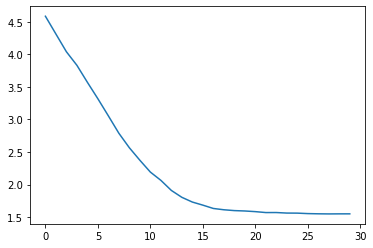

In [ ]:
plt.plot(epoch_losses)

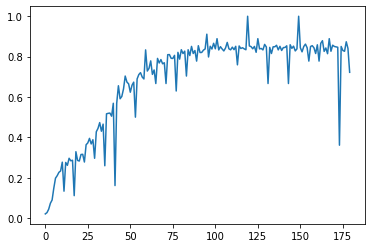

In [ ]:
plt.plot(top_k_precisions)

### Validation on extra images

In [ ]:
extra_dataset = TurtleDataSet(IMAGE_DIR, extra,turtle_ids, transform=img_transform, include_orientation=False)

In [ ]:
model_conv.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
data_loader = torch.utils.data.DataLoader(extra_dataset, batch_size=128, shuffle=False, num_workers=1)
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
preds = []
image_ids = []
val_precisions = []
with torch.no_grad():
    for sample in pbar:
        out = model_conv(sample['img'].to(device))
        # break
        top_k_precision = mapk(sample['id'], out.topk(5, dim=1).indices)
        val_precisions.append(top_k_precision)
        pred = out.topk(5, dim=1).indices.cpu().numpy()
        preds.append(pred)


100%|██████████| 84/84 [11:22<00:00,  8.13s/it]


In [ ]:
np.mean(val_precisions)

0.7580047123015874

In [ ]:
reserved_mem = torch.cuda.memory_reserved(0)
allocated_mem = torch.cuda.memory_allocated(0)

mem_use = allocated_mem/reserved_mem

In [ ]:
mem_use

0.020576755355738992

## As Margin Maximization

### Dataset for Embedding Loss

In [41]:
# Dataset to generate triplets (anchor, positive, negative) for training
class EmbeddingDataset(Dataset):

    def __init__(self, root_dir, labels_df, num_samples, easy_mode=False, transform=None):

        self.root_dir = root_dir
        self.df = labels_df
        self.num_samples = num_samples
        self.samples = self.generate_samples(self.df, self.num_samples, easy_mode)
        self.easy_mode = easy_mode
        self.transform = transform


    @staticmethod
    def generate_samples(df, num_samples, easy_mode):

        def make_dictionary_for_turtle_classes(df, easy_mode):
            
            turtle_classes = {}
            if easy_mode:
                orientations = df['image_location'].unique().tolist()

                for turtle_id in df['turtle_id'].unique():
                    turtle_classes[turtle_id] = {}
                    for orientation in orientations:
                      turtle_image_ids = df[(df['turtle_id']==turtle_id) & (df['image_location']==orientation)]['image_id'].tolist()
                      turtle_classes[turtle_id][orientation]=turtle_image_ids
            else:
              for turtle_id in df['turtle_id'].unique():
                turtle_image_ids = df[df['turtle_id']==turtle_id]['image_id'].tolist()
                turtle_classes[turtle_id]=turtle_image_ids
            return turtle_classes

        samples = []
        classes = df['turtle_id'].unique()
        turtle_classes = make_dictionary_for_turtle_classes(df, easy_mode)

        for _ in range(num_samples):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''
            is_positive_sample = random.choice([True, False])
            
            # print(turtle_classes)
            if is_positive_sample:
                pos_class = turtle_classes[np.random.choice(classes)]
                if easy_mode:
                    # Randomly choose an orientation
                    orientations = list(pos_class.keys())
                    # We want to train on turtles which have at least been photographed from orientations
                    while len(orientations) < 2:
                        pos_class = turtle_classes[np.random.choice(classes)]
                        orientations = list(pos_class.keys())
                    
                    orientation = random.choice(orientations)
                    while len(pos_class[orientation])<2:
                        orientation = random.choice(orientations)
                    image_ids = np.random.choice(pos_class[orientation], 2, replace=False)
                else:
                    # print(pos_class)
                    while len(pos_class)<2:
                        pos_class = turtle_classes[np.random.choice(classes)]
                    image_ids = np.random.choice(pos_class, 2, replace=False)
                sample = (image_ids[0], image_ids[1], 1)
            else:
                pos_class = turtle_classes[np.random.choice(classes)]
                neg_class = turtle_classes[np.random.choice(classes)]
                
                if easy_mode:
                    # Randomly choose an orientation
                    orientation = random.choice(list(pos_class.keys()))
                    pos_id = np.random.choice(pos_class[orientation], 1, replace=False)
                    
                    # REsample a negative class if the same orientation is not available
                    while orientation not in neg_class.keys():
                        neg_class = np.random.choice(classes)
                        
                    neg_id = np.random.choice(neg_class[orientation], 1, replace=False)
                    
                else:
                    
                    pos_id = np.random.choice(pos_class, 1, replace=False)
                    neg_id = np.random.choice(neg_class, 1, replace=False)
                    
                sample = (pos_id[0], neg_id[0], -1)
            
            

            samples.append(sample)
                

        return samples

    def __getitem__(self, idx):
        id1, id2, y = self.samples[idx]

        img1 = os.path.join(self.root_dir, id1 +'.JPG')
        img2 = os.path.join(self.root_dir, id2 +'.JPG')

        img1 = Image.open(img1)
        img2 = Image.open(img2)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, y

    def __len__(self):
        return self.num_samples

In [44]:
# Since this model was pretrained above
# We want to freeze all weights
for param in model_conv.parameters():
    param.requires_grad = False

In [45]:
model_conv

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [47]:
# Add a few new layers to replace the old classifier
num_ftrs = model_conv.fc[0].in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU())
# model_conv.classifier[6] = nn.Linear(num_ftrs,100)

In [ ]:
for param in model_conv.classifier.parameters():
    param.requires_grad = True

### Cosine Embedding Loss

In [48]:
cosine_loss = nn.CosineEmbeddingLoss(margin=0.5)

In [49]:
model_conv.to(device)
model_conv.train()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [58]:
num_training_samples = 4096
batch_size=128

In [59]:
scaler = GradScaler()

optimizer_model = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()),
                             lr=0.001, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_model,
                                                   max_lr=0.001,
                                                   anneal_strategy='linear',
                                                   epochs=10,
                                                   steps_per_epoch=int(num_training_samples/batch_size),
                                                   three_phase=True
                                                   
                                                  )

In [52]:
epoch_losses = []

#### Easy Training

In [60]:
for epoch in range(10):
    dataset = EmbeddingDataset(IMAGE_DIR, train, num_training_samples, transform=img_transform, easy_mode=True)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        img1, img2, y =  sample
        optimizer_model.zero_grad() 
        with autocast():
            op1, _ = model_conv(img1.to(device))
            op2, _ = model_conv(img2.to(device))
            loss = cosine_loss(op1, op2, y.to(device))
            # loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * img1.size(0)
        pbar.set_description('Epoch %d - Loss : %f - Learning Rate : %f' % (epoch+1, loss.item(), lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - Loss %f' % (epoch+1, epoch_loss))

Epoch 1 - Loss : 0.243490 - Learning Rate : 0.000363: 100%|██████████| 32/32 [09:18<00:00, 17.45s/it]


Epoch 1 - Loss 0.245868


Epoch 2 - Loss : 0.224871 - Learning Rate : 0.000687: 100%|██████████| 32/32 [08:49<00:00, 16.55s/it]


Epoch 2 - Loss 0.248206


Epoch 3 - Loss : 0.248781 - Learning Rate : 0.000990: 100%|██████████| 32/32 [08:55<00:00, 16.75s/it]


Epoch 3 - Loss 0.241937


Epoch 4 - Loss : 0.202807 - Learning Rate : 0.000667: 100%|██████████| 32/32 [08:59<00:00, 16.86s/it]


Epoch 4 - Loss 0.224454


Epoch 5 - Loss : 0.187940 - Learning Rate : 0.000343: 100%|██████████| 32/32 [08:54<00:00, 16.69s/it]


Epoch 5 - Loss 0.215974


Epoch 6 - Loss : 0.192449 - Learning Rate : 0.000039: 100%|██████████| 32/32 [08:37<00:00, 16.19s/it]


Epoch 6 - Loss 0.214793


Epoch 7 - Loss : 0.221104 - Learning Rate : 0.000029: 100%|██████████| 32/32 [08:42<00:00, 16.34s/it]


Epoch 7 - Loss 0.214480


Epoch 8 - Loss : 0.221331 - Learning Rate : 0.000020: 100%|██████████| 32/32 [08:41<00:00, 16.29s/it]


Epoch 8 - Loss 0.220609


Epoch 9 - Loss : 0.235930 - Learning Rate : 0.000010: 100%|██████████| 32/32 [08:33<00:00, 16.06s/it]


Epoch 9 - Loss 0.216296


Epoch 10 - Loss : 0.196655 - Learning Rate : -0.000000: 100%|██████████| 32/32 [08:34<00:00, 16.08s/it]

Epoch 10 - Loss 0.212067


In [61]:
np.mean(epoch_losses)

0.2254682925529778

In [62]:
np.mean(epoch_losses)

0.2254682925529778

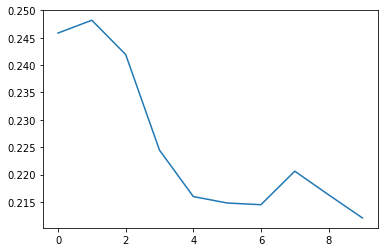

In [63]:
plt.plot(epoch_losses)

Expected 0.19 - 0.18

#### Hard training

In [64]:
batch_size=256

In [65]:
scaler = GradScaler()

optimizer_model = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()),
                             lr=0.001, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_model,
                                                   max_lr=0.001,
                                                   anneal_strategy='linear',
                                                   epochs=10,
                                                   steps_per_epoch=int(num_training_samples/batch_size),
                                                   three_phase=True
                                                   
                                                  )

In [ ]:
for epoch in range(10):
    # The dataset is reinitialized on each epoch so that new samples are generated on evry epoch
    dataset = EmbeddingDataset(IMAGE_DIR, pd.concat([train, extra]).reset_index(drop=True), num_training_samples, transform=img_transform, easy_mode=False)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        img1, img2, y =  sample
        optimizer_model.zero_grad() 
        with autocast():
            op1, _ = model_conv(img1.to(device))
            op2, _ = model_conv(img2.to(device))
            loss = cosine_loss(op1, op2, y.to(device))
            # loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * img1.size(0)
        pbar.set_description('Epoch %d - Loss : %f - Learning Rate : %f' % (epoch+1, loss.item(), lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - Loss %f' % (epoch+1, epoch_loss))

Epoch 1 - Loss : 0.213080 - Learning Rate : 0.000367: 100%|██████████| 16/16 [08:48<00:00, 33.00s/it]


Epoch 1 - Loss 0.207385


Epoch 2 - Loss : 0.201565 - Learning Rate : 0.000694: 100%|██████████| 16/16 [09:00<00:00, 33.76s/it]


Epoch 2 - Loss 0.197888


Epoch 3 - Loss : 0.199880 - Learning Rate : 0.000980: 100%|██████████| 16/16 [09:03<00:00, 33.98s/it]


Epoch 3 - Loss 0.186947


Epoch 4 - Loss : 0.166767 - Learning Rate : 0.000673:  94%|█████████▍| 15/16 [08:28<00:34, 34.23s/it]

In [ ]:
np.mean(epoch_losses)

0.1847549252956274

Expected 0.17 - 0.16

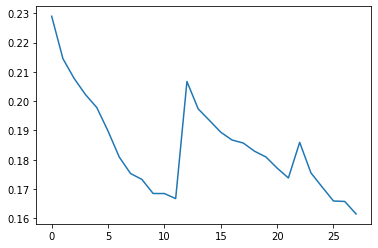

In [ ]:
plt.plot(epoch_losses)

In [ ]:
model_conv.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
cosine_similarity = nn.CosineSimilarity(dim=-1)

In [ ]:
all_train_data = pd.concat([train, extra]).reset_index(drop=True)

all_train_data = all_train_data.sort_values('turtle_id')

In [ ]:
indexing_dataset = TurtleDataSet(IMAGE_DIR, all_train_data, turtle_ids, transform=img_transform, include_orientation=False)

In [ ]:
data_loader = torch.utils.data.DataLoader(indexing_dataset, batch_size=512, shuffle=False, num_workers=1)

In [ ]:
ids = []
emb_index = []
with torch.no_grad():
    for sample in tqdm.tqdm(data_loader):
        emb = model_conv(sample['img'].to(device))
        emb.to('cpu')
        emb_index.append(emb)
        ids.append(sample['id'])


 19%|█████████████████████████████████▋                                                                                                                                             | 5/26 [01:23<06:25, 18.37s/it]

In [ ]:
emb_index = torch.cat(emb_index)

In [ ]:
emb_index.shape

torch.Size([12803, 64])

In [ ]:
test['turtle_id'] = ''

In [ ]:
test_dataset = TurtleDataSet(IMAGE_DIR, test, turtle_ids, transform=img_transform, include_orientation=False)

In [ ]:
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=1)

# data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

test_image_ids = []
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
with torch.no_grad():
    for sample in pbar:
        test_image_ids.extend(sample['image_id'])
        test_emb = model_conv(sample['img'].to(device))
        # break


In [ ]:
test_emb.shape[0]

490

In [ ]:
ids = torch.cat(ids)

ids = ids.numpy()

In [ ]:

preds = []
for idx in range(test_emb.shape[0]):
    pred = cosine_similarity(emb_index, test_emb[idx]).topk(k=5).indices.cpu().numpy()
    pred = list(map(lambda x: ids[x], pred))
    preds.append(pred)

In [ ]:
preds = np.array(preds)

In [ ]:
preds.shape

(490, 5)

In [ ]:
preds = mapper(preds)

In [ ]:
preds[0]

array(['new_turtle', 'new_turtle', 't_id_uJXT7dGu', 't_id_Ts5LyVQz',
       't_id_AOWArhGb'], dtype='<U13')

In [ ]:
len(test_image_ids)

490

In [ ]:
predictions_df = pd.DataFrame({'image_id': test_image_ids,
                               'prediction1': preds[:, 0],
                               'prediction2': preds[:, 1],
                               'prediction3': preds[:, 2],
                               'prediction4': preds[:, 3],
                               'prediction5': preds[:, 4]})

In [ ]:
predictions_df

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,new_turtle,new_turtle,t_id_uJXT7dGu,t_id_Ts5LyVQz,t_id_AOWArhGb
1,ID_57QZ4S9N,new_turtle,new_turtle,new_turtle,t_id_0g31STvR,new_turtle
2,ID_OCGGJS5X,t_id_0g31STvR,new_turtle,t_id_uIlC9Gfo,new_turtle,t_id_D0gA44av
3,ID_R2993S3S,t_id_D0gA44av,t_id_AOWArhGb,new_turtle,new_turtle,t_id_ksTLswDT
4,ID_2E011NB0,t_id_G5eoqwD8,new_turtle,t_id_ROFhVsy2,t_id_fjHGjp1w,new_turtle
...,...,...,...,...,...,...
485,ID_0RVNUKK1,t_id_AOWArhGb,t_id_G5eoqwD8,t_id_4ZfTUmwL,t_id_tjWepji1,new_turtle
486,ID_6405IKG3,new_turtle,new_turtle,new_turtle,new_turtle,new_turtle
487,ID_6WVPVB7S,t_id_ip3jsrYo,t_id_ZfvZBX4Q,t_id_g9Fz8PH7,t_id_MwnEYfqe,new_turtle
488,ID_47C5LL2G,new_turtle,t_id_dVQ4x3wz,new_turtle,new_turtle,new_turtle


In [ ]:
predictions_df.to_csv(os.path.join('predictions', dt.datetime.now().strftime("%Y-%m-%d-%H-%M.csv")),
                      index=False)

In [ ]:
test_emb[0].shape

torch.Size([64])

In [ ]:
sample.keys()

dict_keys(['img', 'image_id', 'id'])

In [ ]:
(sample['id'])

tensor([42,  8, 91, 38, 34, 16, 23,  0, 17, 12, 37, 67, 69, 45, 50, 56, 19,  4,
        33, 92, 23, 60, 73, 47, 79, 65, 81, 89, 13,  6, 97, 48, 50, 54, 54, 55,
        81, 93, 20, 15, 36, 23, 91, 44,  5, 23, 44, 78, 96, 30, 81, 38, 89, 54,
         8, 35, 81, 56, 84, 94, 44, 20, 83,  7, 22, 75, 30, 47, 45, 13, 16, 45,
        80, 54, 42,  8, 15, 29, 25, 87, 84, 54, 62,  3, 86,  3, 38, 23, 87, 85,
        73, 47, 42, 47, 57, 64, 41, 47,  6, 33,  3, 54, 29, 15, 73, 54, 56,  0,
        27, 78, 46, 60, 10, 54, 76, 56, 49, 42, 51, 48, 38, 63, 61, 45, 46, 56,
         3, 23, 79, 84,  8, 88, 72, 82, 33, 94, 28, 89, 58, 48, 73, 72, 65, 67,
        98, 67, 59, 40, 60, 43,  2, 90, 55, 13, 20, 84, 28, 65, 10, 63, 50, 81,
        80, 14, 41, 76, 58, 97,  3, 26, 68, 70, 28, 66,  7, 28, 23, 75, 49, 36,
        83, 56, 84, 35, 56, 84, 38,  9, 56,  9, 76, 66, 21, 33,  4, 63, 42, 66,
        42, 94,  9, 85, 23, 36, 33,  5, 69,  2, 87, 35, 54, 44, 46, 98, 92, 33,
         3, 33, 54, 37, 62, 37, 90, 32, 

In [ ]:
sample.keys()

In [ ]:
len(indexing_dataset)

12803

### Triplet Loss

In [ ]:
triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity(), margin=0.01)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset = TripletDataset(IMAGE_DIR, train, 32768, transform=img_transform, easy_mode=True)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [ ]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6144MB, multi_processor_count=30)

In [ ]:
scaler = GradScaler()

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
pbar = tqdm.tqdm(data_loader)
# with torch.set_grad_enabled(True):
for triplet in pbar:
    optimizer_model.zero_grad() 
    with autocast():
        anc_embed = model_conv(triplet['anc_img'].to(device))
        pos_embed = model_conv(triplet['pos_img'].to(device))
        neg_embed = model_conv(triplet['neg_img'].to(device))
        loss = triplet_loss(anc_embed, pos_embed, pos_embed)
    scaler.scale(loss).backward()
    scaler.step(optimizer_model)
    scaler.update()
    pbar.set_description('Loss : %f' % loss.item())


Loss : 0.010000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [36:59<00:00,  1.85it/s]


In [ ]:
reserved_mem = torch.cuda.memory_reserved(0)
allocated_mem = torch.cuda.memory_allocated(0)

In [ ]:
from google.colab import files

predictions_from_scratch.to_csv('submission.csv')
files.download('submission.csv')

## Generate Result for test set

In [ ]:
test['turtle_id'] = ''

In [ ]:
model_conv.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
test_dataset = TurtleDataSet(IMAGE_DIR, test, turtle_ids, transform=img_transform, include_orientation=False)

In [ ]:
len(test_dataset)

490

In [ ]:
torch.cuda.empty_cache()

In [ ]:
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=70, shuffle=False, num_workers=1)

# data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

preds = []
image_ids = []
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
with torch.no_grad():
    for sample in pbar:
        image_ids.extend(sample['image_id'])
        test_emb = model_conv(sample['img'].to(device))
        pred = test_emb.topk(5, dim=1).indices.cpu().numpy()
        preds.append(pred)
        # break


100%|██████████| 7/7 [00:30<00:00,  4.43s/it]


In [ ]:
image_ids = list(map(lambda x:x.upper(), image_ids))

In [ ]:
preds = np.concatenate(preds)

In [ ]:
sum(preds==100)

array([96, 39, 17, 15, 16])

In [ ]:
sum(preds==100)

array([65, 31, 29, 24, 12])

In [ ]:
preds = mapper(preds)

predictions_df = pd.DataFrame({'image_id': image_ids,
                               'prediction1': preds[:, 0],
                               'prediction2': preds[:, 1],
                               'prediction3': preds[:, 2],
                               'prediction4': preds[:, 3],
                               'prediction5': preds[:, 4]})

In [ ]:
os.makedirs('predictions')

FileExistsError: ignored

In [ ]:
predictions_df.to_csv(os.path.join('predictions', dt.datetime.now().strftime("%Y-%m-%d-%H-%M.csv")),
                      index=False)

In [ ]:
from google.colab import files

In [ ]:
os.listdir('predictions')

['2022-03-10-16-07.csv', '2022-03-10-18-39.csv']

In [ ]:
files.download('predictions/2022-03-10-18-39.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sample_submission = read_csv_from_web('sample_submission.csv')

In [ ]:
sample_submission.head()

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
1,ID_57QZ4S9N,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
2,ID_OCGGJS5X,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
3,ID_R2993S3S,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
4,ID_2E011NB0,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor


In [ ]:
sample['img'].shape

torch.Size([8, 3, 128, 128])

In [ ]:
sample['id']

tensor([26,  8, 76, 60, 66, 66, 55, 34])

In [ ]:
mapk(sample['id'], out.topk(5, dim=1).indices)

0.14583333333333331

In [ ]:
mapk(out,)

In [ ]:
predictions = predictions_from_scratch[[
    "prediction1", "prediction2", "prediction3", "prediction4", "prediction5"
]]
y_predict = predictions.values.tolist()

# We don't actually know the true labels for the test set, so for the purposes
# of demonstration we just assume that all of the images in the test set are of
# a single turtle:
assumed_y = ["t_id_d6aYXtor"] * len(y_predict)

mapk_result = mapk(assumed_y, y_predict, k=5)
print("With made up test set labels, our mapk with k=5 is", mapk_result)

In [ ]:
import tqdm

from torch.cuda.amp import GradScaler, autocast

In [ ]:
class TurtleNet(nn.Module):
    def __init__(self, num_classes, num_orientations, embedding_size):
        super(TurtleNet, self).__init__()
        
        basenet = torchvision.models.alexnet(pretrained=True)
        
        self.features = basenet.features
        # Freeze the conv weights of the pretrained model
        for param in self.features.parameters():
            param.requires_grad = False
        self.adpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.dense_layers0 = basenet.classifier
        self.dense_layers0[6] = nn.Linear(in_features=4096, out_features=128, bias=True)
        
        # self.dense_layers1 = nn.Sequential(nn.ReLU(), nn.Linear(in_features=1024, out_features=256, bias=True), nn.ReLU())
        # self.dense_layers2 = nn.Sequential(nn.Linear(in_features=512, out_features=256, bias=True), nn.ReLU())
        
        self.embedding_head = nn.Sequential(nn.Linear(in_features=128, out_features=embedding_size, bias=True), nn.ReLU())
        self.classification_head = nn.Sequential(nn.Linear(in_features=128, out_features=num_classes, bias=True), nn.ReLU())
        self.orientation_head = nn.Sequential(nn.Linear(in_features=128, out_features=num_orientations, bias=True), nn.ReLU())

    def forward(self, x):
        x = self.features(x)
        x = self.adpool(x)
        x = self.dense_layers0(x)
        x = self.dense_layers1(x)
        
        y_aux = self.orientation_head(x)
        y_main = self.classification_head(x)
        y_emb = self.embedding_head(x)
        
        
        
        return y_main, y_aux, y_embed

In [ ]:
model = TurtleNet(num_classes=len(turtle_ids)+1, # +1 for the new turtle class
                  num_orientations=3, 
                  embedding_size=64)

In [ ]:
optimizer = optim.SGD(
            params=filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [ ]:
img_transform = transforms.Compose([
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [ ]:
dataset = TurtleDataSet(IMAGE_DIR, train_df, turtle_ids, transform=img_transform, include_orientation=True)

In [ ]:
cross_entropy = nn.CrossEntropyLoss()

In [ ]:
model.to(device)
model.train()

TurtleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers0): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=

In [ ]:
torch.cuda.empty_cache()

In [ ]:
scaler = GradScaler()

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                 base_lr=0.00001, 
                                                 max_lr=0.001, 
                                                 step_size_up=21, 
                                                 step_size_down=42)

In [ ]:
top_k_precisions = []
epoch_losses = []

In [ ]:
sample['id']

tensor([ 73,  15,   8,  38,  48,  81,  72,  47,  75,  61,  56, 100,  65,  39,
          4,  81])

In [ ]:
sample['orientation']

tensor([0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1])

In [ ]:
model.to('cpu')
model.train()

TurtleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (dense_layers0): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tru

In [ ]:
model(sample['img'])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (24576x6 and 9216x4096)

In [ ]:
for epoch in range(25):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        optimizer.zero_grad() 
        with autocast():
            op_main, op_aux, op_embed = model(sample['img'].to(device))
            loss1 = cross_entropy(op, sample['id'].to(device))
            loss2 = cross_entropy(op, sample['orientation'].to(device))
            loss = loss1+0.4*loss2
            
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss1.item() * sample['img'].size(0)
        top_k_precision = mapk(sample['id'], op_main.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pbar.set_description('Epoch %d - MAP@k : %f - Learning Rate : %f' % (epoch+1, top_k_precision, lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - MAP@k : %f - Loss %f' % (epoch+1, np.mean(top_k_precisions[-21:]), epoch_loss))

  0%|                                                                                                                                                                                      | 0/164 [00:00<?, ?it/s]/home/xion/.conda/envs/torchenv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                                                                                                                      | 0/164 [00:02<?, ?it/s]

 ** On entry to GEMM_EX  parameter number 12 had an illegal value


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasGemmEx( handle, opa, opb, m, n, k, &falpha, a, CUDA_R_16F, lda, b, CUDA_R_16F, ldb, &fbeta, c, CUDA_R_16F, ldc, CUDA_R_32F, CUBLAS_GEMM_DFALT_TENSOR_OP)`

In [ ]:
torch.cuda.empty_cache()

### Custom Model
Trained from scratch

In [ ]:
class TurtleNet(nn.Module):
    def __init__(self):
        super(TurtleNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Flatten()
        )
        
        self.feature_classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=32768, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=100, bias=True)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.feature_classifier(x)
        return x 

In [ ]:
model_conv = TurtleNet()

In [ ]:
img_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [ ]:
# Clear out anymemory if possible
torch.cuda.empty_cache()

In [ ]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
scaler = GradScaler()

In [ ]:
dataset = TurtleDataSet(IMAGE_DIR, train, transform=img_transform)

In [ ]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [ ]:

# with torch.set_grad_enabled(True):
for epoch in range(10):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    for sample in pbar:
        # break
        optimizer_model.zero_grad() 
        with autocast():
            op = model_conv(sample['img'].to(device))
            loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        pbar.set_description('Epoch %d - Loss : %f' % (epoch+1, loss.item()))


Epoch 10 - Loss : 4.625000: 100%|███████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.51it/s]
